# Solution to Data Science Test

### Table of Contents

* [Introduction](#introduction)
* [Definition of the Problem](#definition)
* [Solutions Roadmap](#roadmap)
    * [Models](#models)
    * [Metrics](#metrics)
    * [Benchmark](#metrics)
* [Implementation](#implementation)
    * [Data Preprocessing](#preparation)
        * [Feature Engineering](#engineering)
        * [Missing Values](#missing)
        * [Ouliers](#outliers)
    * [Feature Selection](#selection)
    * [Traning](#traintest)
        * [Exploring the Hyperparameter Space](#space)
        * [Hyperparameter Tuning](#tuning)
    * [Testing](#results)
* [Results Analysis](#analysis)
    * [Feature Importance](#importance)
    * [Probabilities and Percentiles](#probs)
    * [Behavioural Patterns](#patterns)
* [Recommendations](#recommendations)
* [Appendix](#appendix)

## Introduction <a class="anchor" id="introduction"></a>

This notebook presents the solution to the Data Science Test in depth. I build a XGBoost model to predict customer churning for CompanyX. Nested cross-validation reported an F1 of 0.877 and a ROC-AUC of 0.925, on average. The model was able to correctly identify **all** the churning customers from previously unseen data (17 out of 99 cases) and only one non-churning customer (out of 82) was mistakenly classified as churning. Hence F1 over the testing set was of 0.97 (precision of 1 and recall of 0.94). Feature importance extracted from the model suggests that activity pertaining to Process C is crucial to separate churning from non-churning customers, and I confirm it by analysing churning probabilities and user behaviour over time.   

The rest of this document is structed as follows. First, I define the problem as I understood it, in order to define the scope of interpretations that can be made out of the model. Next, I delineate the solution's roadmap, justifying the choice of modelling framework, metrics and benchmark. Then, I describe model implementation in detail, including data preprocessing, feature selection, training and testing. Finally, I analyse the results, giving insights and recommendations that emerge from my discoveries. 


## Definition of the Problem <a class="anchor" id="definition"></a>

![](flow.png)
![](uml.png)


## Solution's Roadmap <a class="anchor" id="roadmap"></a>

### Models <a class="anchor" id="models"></a>

In order to choose modelling frameworks that could help solving the problem at hand, I often think about constraints imposed by the data. As I show in section [Data Preprocessing](#preparation), the final dataset had the following properties:

* Few data points (around 600 from origninally 17k+). Models that support it naturally: SVM, Naive Bayes, Ensembles (e.g. XGBoost).
* Class imbalance of 6:1. Undersampling was not an option because I would end up with too few data points, while oversampling would probably not work considering the size of the dataset and the severity of imbalance. Models that handle imbalance through weights: SVM, Logistic Regression, and XGBoost in some cases.

From this list, we see that SVM, Logistic Regression and XGBoost are the best options. My strategy with those models, based on previous experience with their accuracy, computational time, and complexities, was:

1. Build an optimized Logistic Regression. If results are not satisfactory, save this model and move on to the next step. Otherwise, stop and use it for analysis. Simple models should be preferred over complex ones and there's nothing simpler than a linear model.
2. Build an optimized XGBoost. If results are satisfactory, stop and use it for analysis, since it's difficult to beat XGBoost in classification problems. Otherwise, try SMOTE. If results are not satisfactory, save this model and move on to the next step.
3. Build an optimized SVM. If results are not satisfactory, save this model and move on to the next step. Otherwise, stop and use it for analysis. 
4. Take the majority vote from the three previous weak classifiers. Most likely, combining the responses of these uncorrelated models will decrease variance (overfitting) while preserving or incresing the bias (accuracy).

As I will show in section [Models](#models), I only needed to go as far as step 2 to obtain an excellent classifier, without SMOTE.

### Metrics <a class="anchor" id="metrics"></a>

Metrics must be meaningful in terms of the outcome we desire. Accuracy would not work well here, since it could simply reflect the fact that the model is predicting which customers are not going to churn (the majority case). ROC-AUC is always a good reference, but there are better metrics for our problem out there, such as:

* Precision: We need to make sure we're catching as many churning customers as possible. False positives are not so important. But they are costly. We don't want to target them with expensive marketing, offers or training. 
* Recall: We need to make sure that if we're classifying a customer as churning, he's really a churning customer, because targeting them might be expensive. But, sometimes, we're better safe than sorry.

Considering this, I chose F1 as the target metric for optimising my models, since it is a balance between precision and recall.

### Benchmark  <a class="anchor" id="benchmarks"></a>

The benchmark model was the weak classifier obtained from an optmized Logistic Regression model, as decribed [here](#models).

## Implementation <a class="anchor" id="implementation"></a>

In this section we will cover the final model's implementation and design, from data preprocessing to results. We selected the XGBoost framework for its outstanding performance relative to Logistic Regression (and in fact any reasonable criteria). Details about the implementation of this benchmark model can be found in the [Appendix](#appendix).

For the code to work properly, the following libraries are necessary and configurations below them are optional, but recommended: 

In [1]:
import warnings
from IPython.core.display import display, HTML

# Date and Time
import time
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Math and Stats
import numpy as np
import scipy.stats as ss
import math

# Data Manipulation
import pandas as pd
import itertools

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

# Scikit-Learn
import sklearn.metrics as sklm
import sklearn.preprocessing as pp
from sklearn import model_selection as ms
from sklearn.feature_selection import RFE

# Personal library
import custom_manip as cm
import custom_plots as cp
import custom_algrt as ca 

pd.set_option('display.max_rows', None)
np.random.seed(2345)
warnings.simplefilter("ignore")

/home/talithafs/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/talithafs/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Notice that I import *custom_manip* as *cm*, *custom_plots* as *cp*, and *custom_algrt* as *ca*. They contain functions that are part of my personal library for data manipulation, plotting, and machine learning. I will use them throughout the modelling process.

## Data Preprocessing <a class="anchor" id="preparation"></a>

We first take a brief look at the main table, which I call *customer* table:

In [2]:
customer = pd.read_csv('test_dataset.csv', sep = ';').iloc[:,1:]
customer.head()

,customer,contractid,year,quarter,month,contract_type,startdate,enddate,is_active,A_true,...,BORRAR_4,BORRAR_5,BORRAR_6,BORRAR_7,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,BORRAR_8,B_false
0,393,16,2019,4,12,Piracy,1515456000000,NaN,active,1198.0,...,NaN,NaN,42.0,46.0,45.0,0.35,NaN,NaN,NaN,NaN
1,393,16,2020,3,8,Piracy,1515456000000,NaN,active,7250.0,...,NaN,NaN,1.0,1.0,NaN,0.98,NaN,NaN,NaN,NaN
2,393,16,2020,1,3,Piracy,1515456000000,NaN,active,803.0,...,NaN,NaN,0.0,0.0,NaN,0.28,NaN,NaN,NaN,NaN
3,393,16,2018,3,7,Piracy,1515456000000,NaN,active,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,393,16,2020,3,9,Piracy,1515456000000,NaN,active,8049.0,...,NaN,NaN,0.0,0.0,29.0,1.00,NaN,NaN,NaN,NaN


In [3]:
customer.columns

Index(['customer', 'contractid', 'year', 'quarter', 'month', 'contract_type',
       'startdate', 'enddate', 'is_active', 'A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'BORRAR',
       'BORRAR_2', 'avg_time_start_C_true', 'median_time_start_C_true',
       'min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true', 'BORRAR_3',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'BORRAR_4', 'BORRAR_5', 'BORRAR_6', 'BORRAR_7',
       'avg_B_true_C_false', 'automatization_A', 'automatization_B',
       'automatization_C', 'BORRAR_8', 'B_false'],
      dtype='object')

We notice that some columns can be dropped right away:

In [4]:
to_drop = cm.get_cols(customer,'BORRAR')
customer.drop(to_drop,axis=1,inplace=True)

Now we quickly examine the other two tables that were provided:

In [5]:
conversion = pd.read_csv('test_conversion.csv').iloc[:,1:]
other = pd.read_csv('test_other_dataset.csv').iloc[:,1:]

conversion.head()

,sf_account_id,contractid
0,NaN,21.0
1,NaN,22.0
2,NaN,23.0
3,NaN,24.0
4,NaN,25.0


In [6]:
conversion.isna().sum()/conversion.shape[0]

sf_account_id    0.791128
contractid       0.061922
dtype: float64

80% of values are missing at **sf_account_id**. The table *conversion* is possibly malformed.

In [7]:
other.head()

,Company Type,Plan Tier,Country,Business Unit,Industry,Vertical,Contract Start Date,Contract End Date,sf_account_id
0,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2020-04-01,440
1,SMB,NaN,UNITED STATES,2,E-Learning,Content Creator,2020-01-08,2020-04-07,1384
2,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2019-11-01,454
3,SMB,Tier 3,GERMANY,1,Sports & Outdoor,General Sports,2019-03-19,2020-04-20,1052
4,SMB,Tier 3,UNITED STATES,1,Fashion,Accessories,2019-12-13,2020-06-13,1294


In [8]:
print("Number of contracts in 'other': " + str(len(other.sf_account_id.unique())))
print("Number of contracts with additional info: " + str(len(conversion.sf_account_id.unique())))
print("Number of contracts in 'customer': " + str(len(customer.contractid.unique())))

Number of contracts in 'other': 1492
Number of contracts with additional info: 149
Number of contracts in 'customer': 500


Only 149 contracts in the *conversion* table can be mapped to the *customer* table, out of 500 possible contracts in the *customer* table. This means that a maximum of 30% of contracts in the *customer* table has additional information. Since there are not many of such cases, we first focus on cleaning and engineering the *customer* table. Only then we will be able to decide if it makes sense to use the additional information. 

A side note: 'other' contains several duplicates (repeated contracts have the same additional information), besides contracts that are not listed in 'customer'.

###  Feature Engineering <a class="anchor" id="engineering"></a>

We first need to verify two things:
1. Does a missing **enddate** mean the contract is still active? If this is the case, we will need to create a new variable to indicate whether a customer has churned or not: if any of his/her contracts is active, then **churned** will be set to 0.
2. Are there any rows with missing **stardate** AND missing **enddate**? If not, we can build a new variable: **contract_duration**. Else, we can drop these rows and still create the new variable, provided there are not many of those rows.

Let us start with the first test:

In [9]:
customer.loc[pd.isna(customer.enddate) & customer.is_active == "inactive"].shape

(0, 35)

Hence we need to create the new feature **churned**, as described earlier (0 = customer did NOT churn, 1 = customer CHURNED):

In [10]:
churned = customer.groupby('customer')['is_active'].apply(lambda x : int(any(x == 'inactive'))).reset_index()
churned = churned.rename(columns = {'is_active':'churned'})

**Important**: Throughout this notebook, churning customers will be called *positive* cases (= 1) and non-churning customers, *negative* cases (= 0).

Now for the second test:

In [11]:
customer.loc[pd.isna(customer.startdate) & pd.isna(customer.enddate)].shape

(0, 35)

We can then create **contract_duration** by assuming the missing end dates are equal to today (since it means the customer is still active, as we discovered in the previous step). The variable will be measured in days:

In [12]:
dt = datetime(2020, 11, 20)
today_ms = int(round(dt.timestamp() * 1000))

customer.enddate = customer.enddate.fillna(today_ms)
customer['contract_duration'] = (pd.to_datetime(customer.enddate,unit='ms') - pd.to_datetime(customer.startdate,unit='ms')).dt.days

!!!!! ----- Why is this important?

We also need to decide what to do with the **year**, **quarter**, and **month** features. In my experience, churning is not primarily affected by seasonality, so **quarter** shouldn't be a good predictor. On the other hand, **year** and **month** can be used to construct a new feature that could be tremendously useful: the number of days that the customer was last active, i.e. the time since s/he last used the platform. In order to achieve this, we obtain a **timestamp** column from **year** and **month** and subtract from it one-period-ahead shift from its values:

In [13]:
customer['timestamp'] = pd.to_datetime(customer.year.astype(str)  + customer.month.astype(str), format='%Y%m')
customer.drop(['year','month'], axis=1, inplace=True)

customer = customer.sort_values(['customer','contractid','timestamp'], ascending = False)
days_since_last_active = customer.groupby(['customer','contractid'])['timestamp'].apply(lambda x : (x.shift(1)-x).dt.days).reset_index()
days_since_last_active = days_since_last_active.fillna(0)
customer['days_since_last_active'] = list(days_since_last_active.timestamp)

Now we can evaluate if we're going to need **timestamp**. Let us look at minimum and maximum values:

In [14]:
customer[['timestamp']].apply(lambda x : print(min(x),max(x)))

2018-01-01 00:00:00 2020-10-01 00:00:00


timestamp    None
dtype: object

In the best case scenario (the largest possible contract) we have less than two years of observations, meaning we cannot perform statistically significant time series analysis with this data. We can, however, analyse use behavioural patterns over the number of interactions with the platfomr, which we will do after modelling (section [Results Analysis](#analysis)). But for this purpose we only need the cummulative number of interactions, and not the date when an interaction occured. Hence we will drop **timestamp**.

We take the opportunity to drop the other features we used to creat new ones, since they are no longer needed:

In [15]:
to_keep = ['customer', 'contractid', 'contract_duration', 'contract_type', 'A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'avg_time_start_C_true', 
       'median_time_start_C_true','min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'avg_B_true_C_false', 'automatization_C','days_since_last_active', 'B_false'] 

customer = customer.loc[:,to_keep]

We're almost done preparing *customer* for the next steps. We need to join it with **churned** first:

In [16]:
customer = customer.merge(churned, on='customer')

Now we merge *other* and *conversion* on **sf_account_id**, obtaining the *info* table. On this table we perform the following operations:
1. Drop the id (useless for predictions) and contracts' start date and end date (we have already calculated contract duration)
2. Rename some columns to be in corformity with other names (good practice)
3. Drop duplicates (repeated ids have the same additional information)

In [17]:
info = conversion.merge(other, on='sf_account_id')
info.contractid = info.contractid.astype(int)
info.drop(['sf_account_id','Contract Start Date', 'Contract End Date'], axis=1, inplace=True)
info.rename(columns = {'Company Type':'company_type',
                                      'Plan Tier':'plan_tier',
                                      'Country':'country',
                                      'Business Unit':'business_unit',
                                      'Industry':'industry',
                                      'Vertical':'vertical'}, inplace=True)

info.drop_duplicates(inplace=True)

Additional information can be useful for predictions, so we merge *customer* with *info*. This time, we will *left* merge the two tables, since there are contracts in *info* that are not in *customer* and those are not useful for our purposes, since they contain almost no information besides the additional ones. *Right* merging these tables would create a lot of almost empty rows representing contracts that are not in *customers*, while *inner* merging would reduce the number of rows, keeping only contracts that are in both tables.

In [18]:
customer = customer.merge(info, on='contractid',how='left')
customer.shape

(17034, 36)

We'll keep a copy of *customer* as it is now, so that we can use it to analyse customer behaviour later. 

In [19]:
customer_with_id = customer.copy()
customer.drop(['customer','contractid'],axis=1,inplace=True)

Last step  before dealing with missing values: create a vector containg the names of categorical features and a vector contaning the names of numerical features:

In [20]:
catg = ['company_type','plan_tier', 'country', 'business_unit', 'industry', 'vertical', 'contract_type']
numl = list(customer.drop(catg+['churned'], axis=1).columns)

### Missing Values <a class="anchor" id="missing"></a>

Before anything, we check the percentage of missing values under each column:

In [21]:
nrows = customer.shape[0]
customer.isna().sum()/nrows

contract_duration            0.000000
contract_type                0.009980
A_true                       0.515087
A_false                      0.658565
internal_B_true              0.623576
external_B_true              0.918751
B_true                       0.619467
internal_C_true              0.522367
external_C_true              0.910297
C_true                       0.521310
one_week_B_true_C_true       0.561465
two_weeks_B_true_C_true      0.561465
one_month_B_true_C_true      0.561465
avg_time_start_C_true        0.558354
median_time_start_C_true     0.558354
min_time_start_C_true        0.558354
max_time_start_C_true        0.558354
avg_time_B_true_C_true       0.561465
median_time_B_true_C_true    0.561465
avg_start_A_true             0.577199
avg_start_A_false            0.581719
avg_A_true_B_true            0.573441
avg_A_true_B_false           0.629447
avg_B_true_C_false           0.771809
automatization_C             0.605965
days_since_last_active       0.000000
B_false     

There is a huge amount of missing data. Let us examine the table a little further to see what we can do:

In [22]:
display(HTML("<style>div.output_scroll { height: 20em; }</style>"))
customer.head(100)

,contract_duration,contract_type,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,...,automatization_C,days_since_last_active,B_false,churned,company_type,plan_tier,country,business_unit,industry,vertical
0,652,Brand,123.0,96.0,35.0,NaN,35.0,16.0,NaN,16.0,...,0.00,0.0,24.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,652,Brand,245.0,191.0,62.0,NaN,62.0,20.0,NaN,20.0,...,0.12,30.0,21.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,652,Brand,178.0,205.0,38.0,NaN,38.0,44.0,NaN,44.0,...,0.01,31.0,55.0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,652,Brand,170.0,166.0,77.0,NaN,77.0,64.0,NaN,64.0,...,0.00,31.0,39.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,652,Brand,106.0,302.0,62.0,NaN,62.0,93.0,3.0,96.0,...,0.01,30.0,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,652,Brand,49.0,258.0,21.0,4.0,25.0,44.0,1.0,45.0,...,0.00,31.0,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,652,Brand,58.0,483.0,37.0,NaN,37.0,108.0,1.0,109.0,...,0.00,30.0,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,652,Brand,156.0,213.0,44.0,1.0,45.0,106.0,1.0,107.0,...,0.00,31.0,26.0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,652,Brand,199.0,87.0,100.0,NaN,100.0,54.0,1.0,55.0,...,0.00,29.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,652,Brand,291.0,170.0,79.0,1.0,80.0,76.0,1.0,77.0,...,0.00,31.0,137.0,0,NaN,NaN,NaN,NaN,NaN,NaN


It seems like the system is timestamping users even when there's no new activity to be registered. As a result, many rows are empty for an specific subset of columns. We eliminate those rows:

In [23]:
with_nas = ['A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'avg_time_start_C_true', 
       'median_time_start_C_true','min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'avg_B_true_C_false', 'automatization_C', 'B_false']

customer = customer.dropna(subset = with_nas)
customer.isna().sum()

contract_duration              0
contract_type                  0
A_true                         0
A_false                        0
internal_B_true                0
external_B_true                0
B_true                         0
internal_C_true                0
external_C_true                0
C_true                         0
one_week_B_true_C_true         0
two_weeks_B_true_C_true        0
one_month_B_true_C_true        0
avg_time_start_C_true          0
median_time_start_C_true       0
min_time_start_C_true          0
max_time_start_C_true          0
avg_time_B_true_C_true         0
median_time_B_true_C_true      0
avg_start_A_true               0
avg_start_A_false              0
avg_A_true_B_true              0
avg_A_true_B_false             0
avg_B_true_C_false             0
automatization_C               0
days_since_last_active         0
B_false                        0
churned                        0
company_type                 639
plan_tier                    639
country   

Fortunately, there are no more missing values in numerical variables. To deal with missing values in categorical variables, we'll simply define them as a new category: 'Not Available'. Sometimes no information IS information. For instance, maybe those values are missing because this is an special kind of client that requires privacy. 

In [24]:
info_cols = list(info.columns)[1:]
customer[info_cols] = customer[info_cols].fillna('NotAvailable')

### Outliers  <a class="anchor" id="outliers"></a>

Identifying and handling outliers is done in a single loop, so before performing these operations, we look at the distribuitions of numerical features to figure out what to do with those outliers. If the distribution of a given column is skewed, it is safe to replace outliers with the median of that column, whereas normal distributions make means more appropriate.   

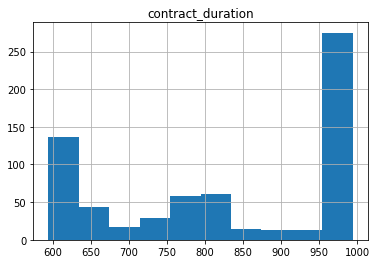

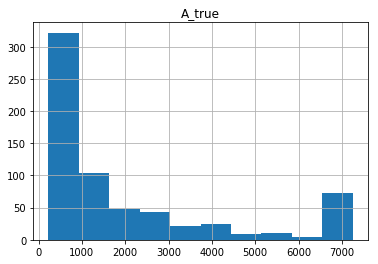

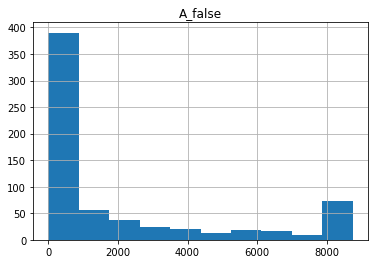

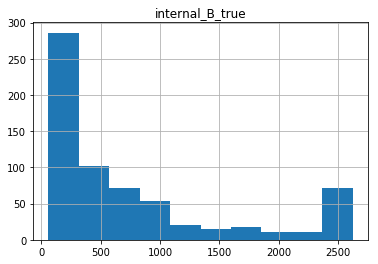

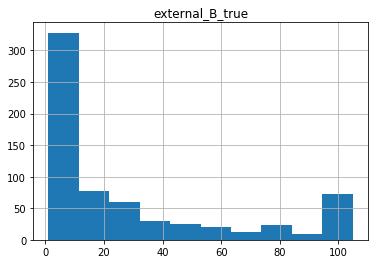

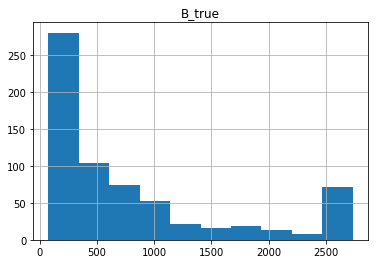

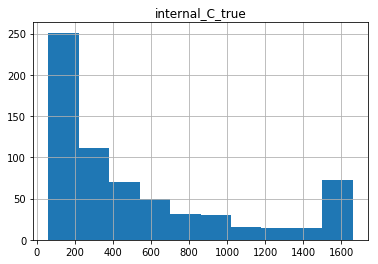

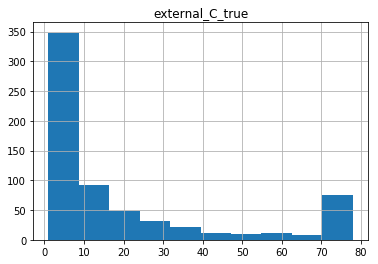

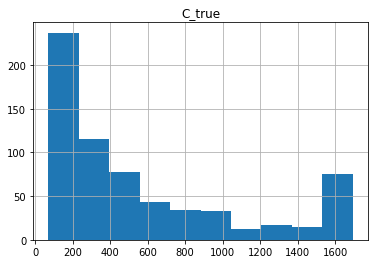

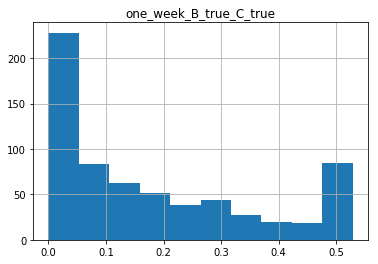

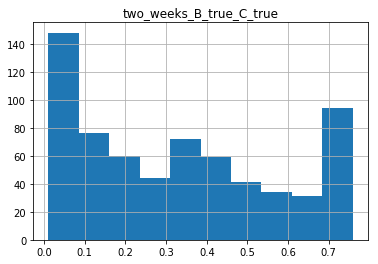

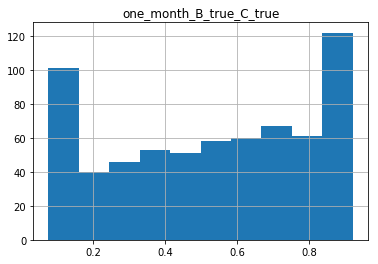

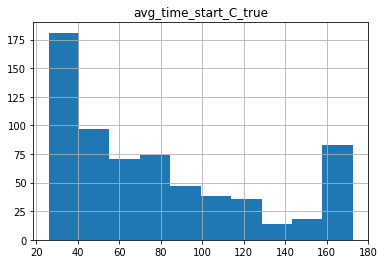

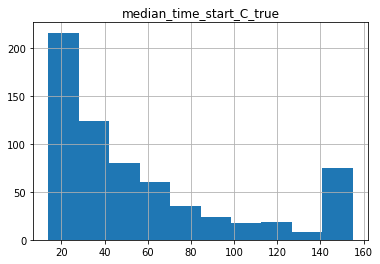

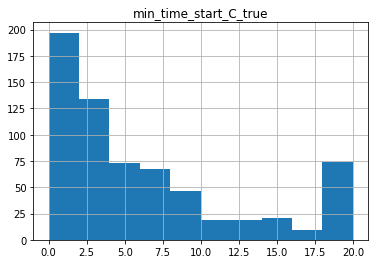

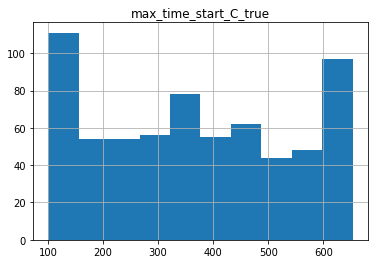

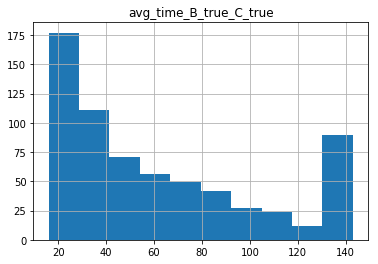

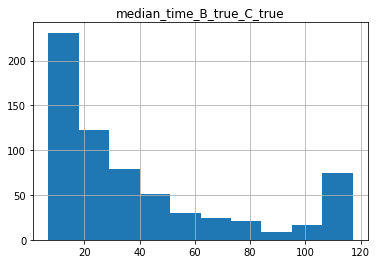

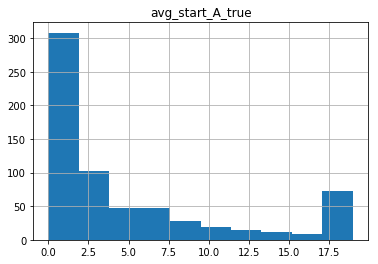

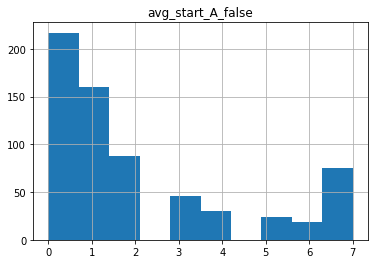

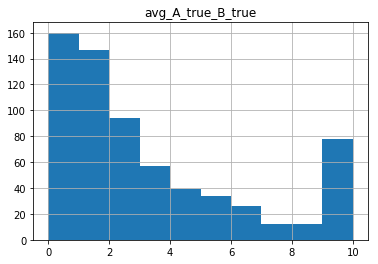

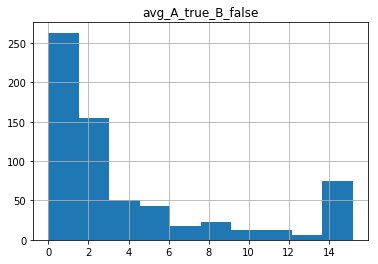

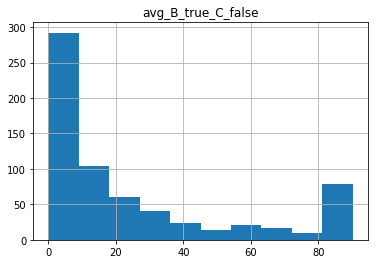

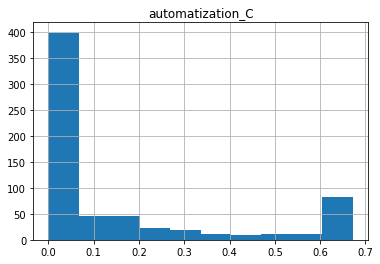

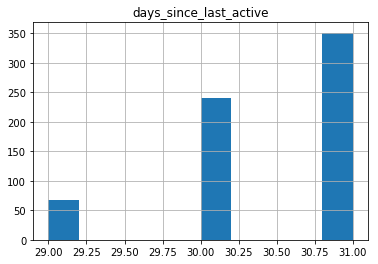

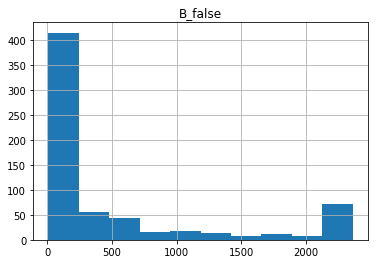

In [25]:
cp.plot_hists(customer,numl)

All the distributions are skewed. In general, machine learning algorithms work better when features' distributions are normal, so I apply the log over each column to see if they become approximately normal (not the *logs* parameter):

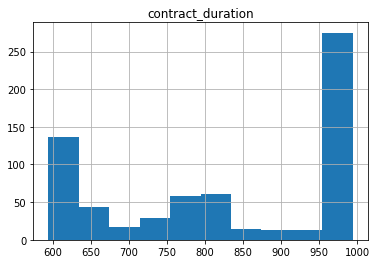

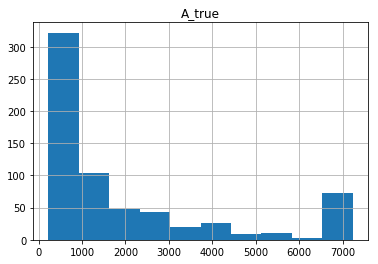

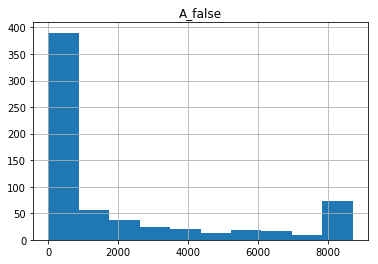

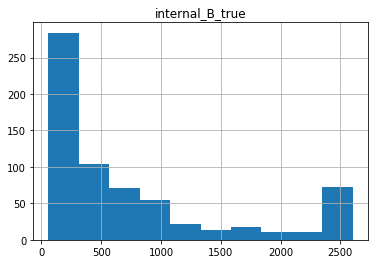

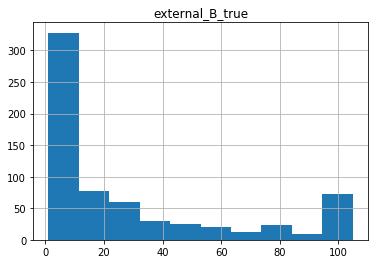

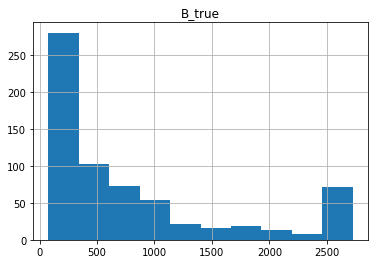

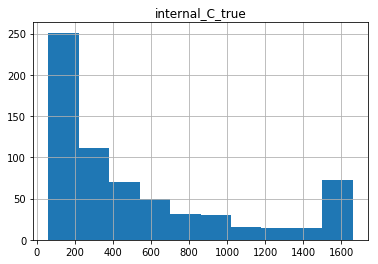

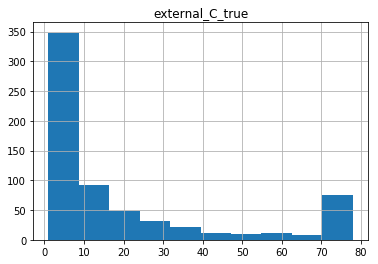

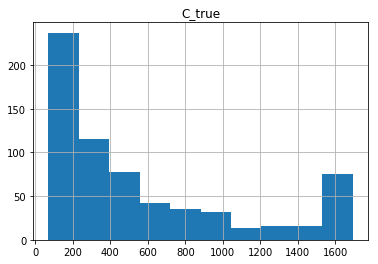

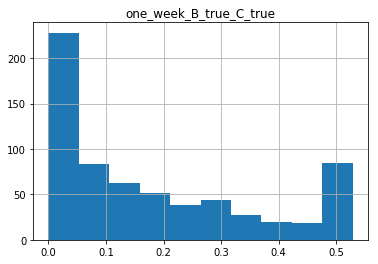

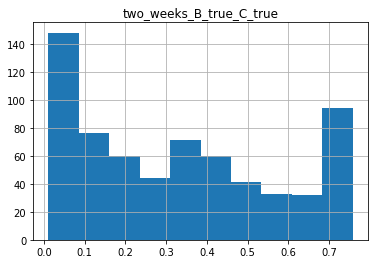

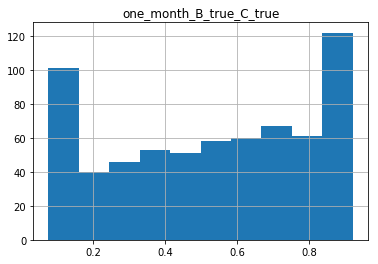

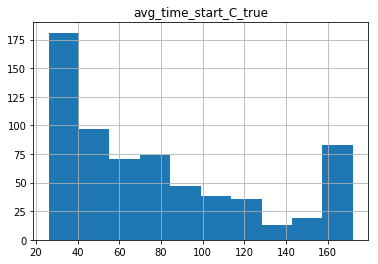

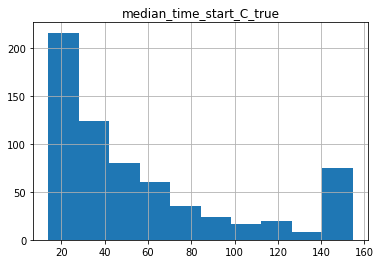

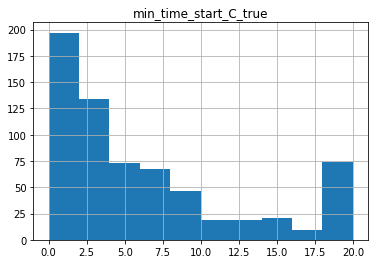

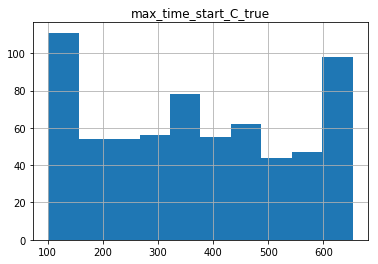

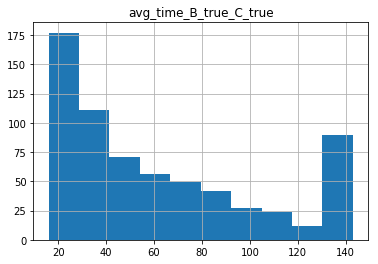

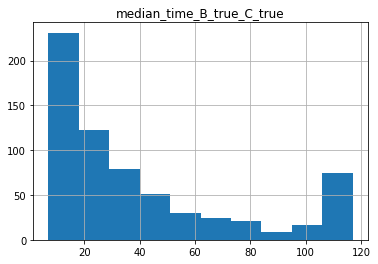

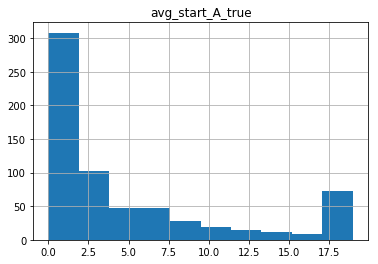

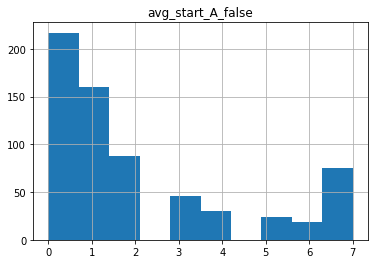

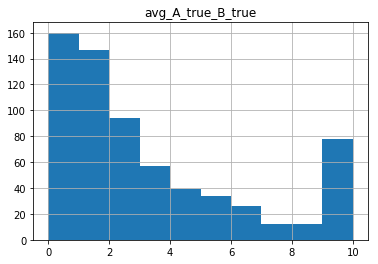

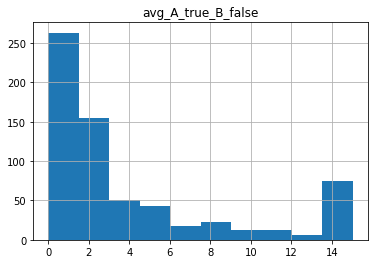

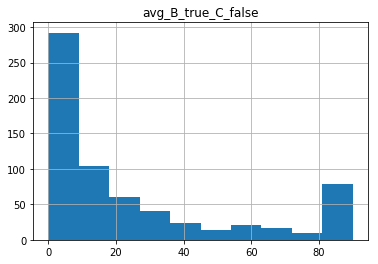

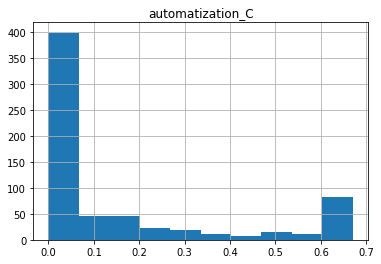

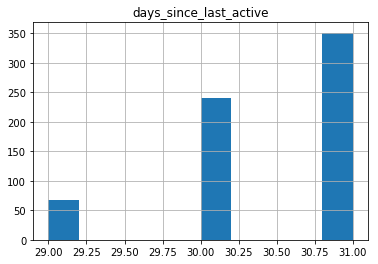

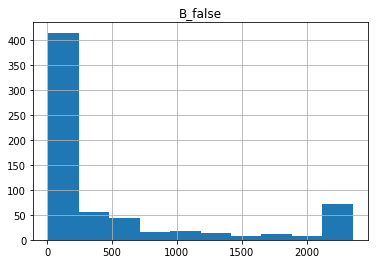

In [26]:
cp.plot_hists(customer,numl,logs=True)

Log transformations do not work, so we use the median to replace outliers, which are defined as values with high z-scores (above 2.4):

In [27]:
def subs_outliers(x):
    std = pd.Series(ss.zscore(x))
    mask = list(std.map(lambda y : True if y >= 2.4 else False))
    #print(x[mask])
    x[mask] = np.median(x)
    return x

customer[numl] = customer[numl].apply(subs_outliers)

## Feature Selection <a class="anchor" id="selection"></a>

### Categorical Features

In [28]:
customer.churned.value_counts()

0    567
1     92
Name: churned, dtype: int64

In [29]:
data = cm.rebalance(customer, 'churned')

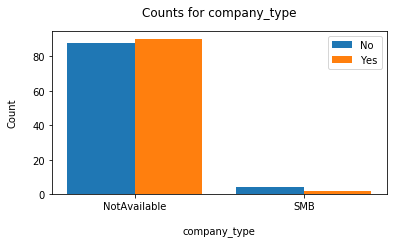

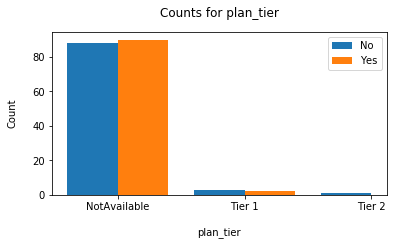

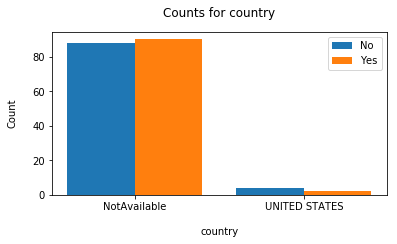

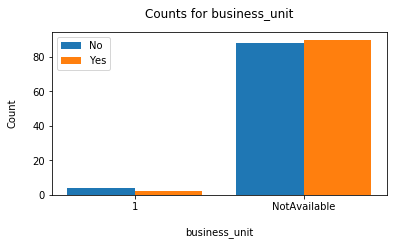

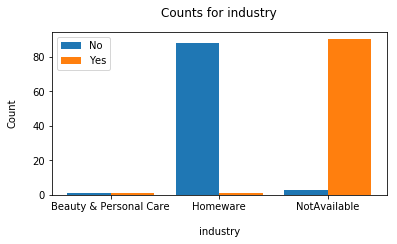

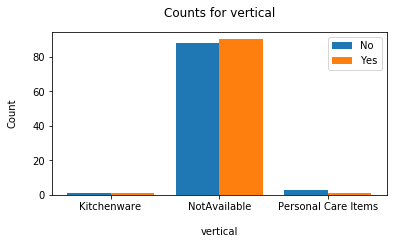

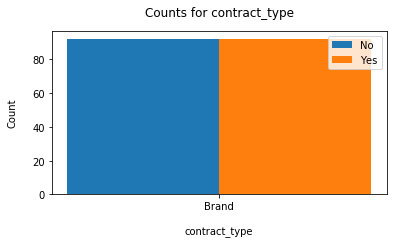

In [30]:
cp.plot_bars(data,catg,'churned')

In [31]:
customer.drop(['company_type',
                 'plan_tier',
                 'country',
                 'business_unit',
                 'contract_type'],axis=1,inplace=True)
catg = ['industry','vertical']

### Numerical Features

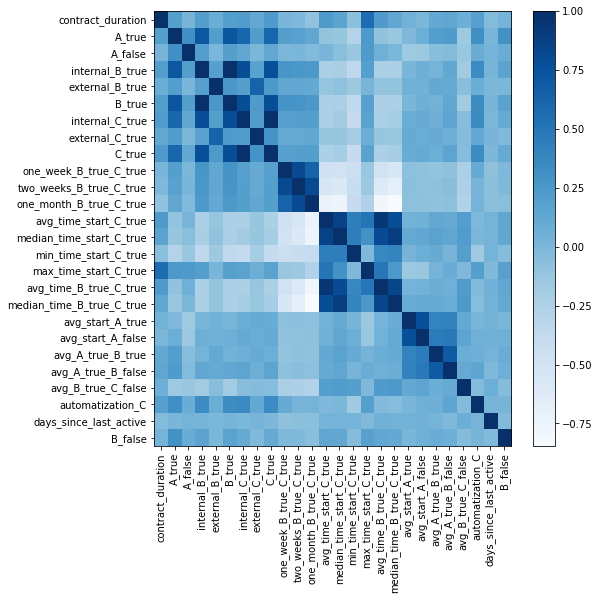

In [32]:
cp.heatmap(customer[numl])

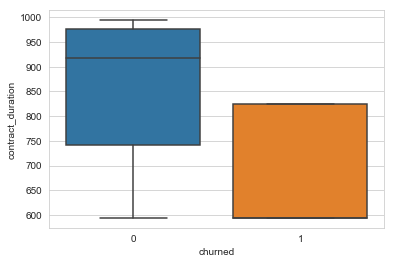

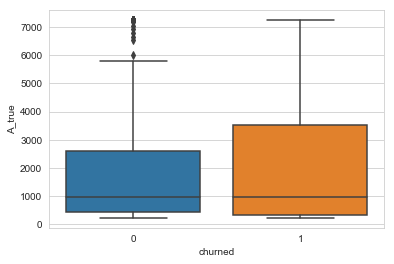

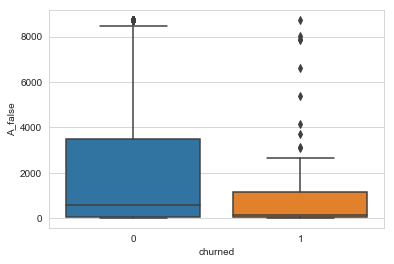

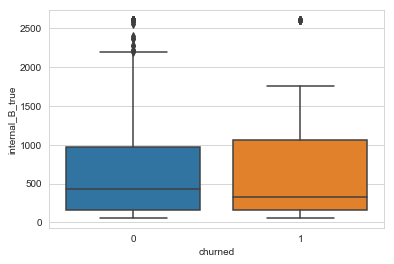

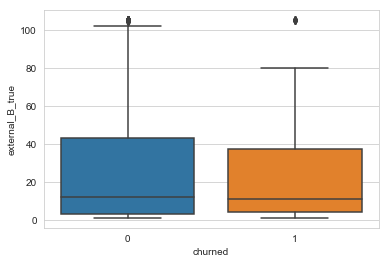

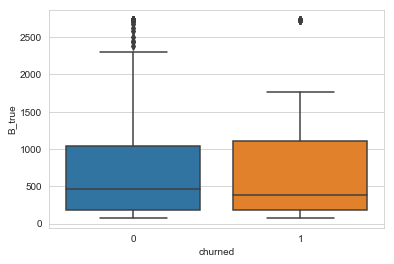

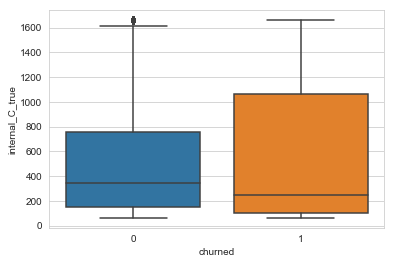

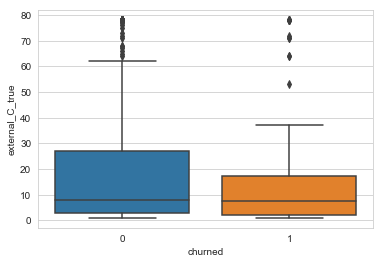

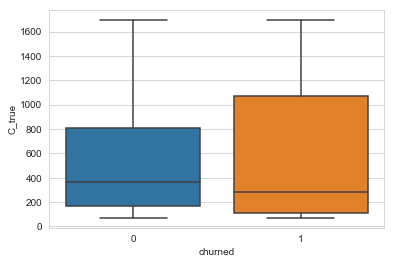

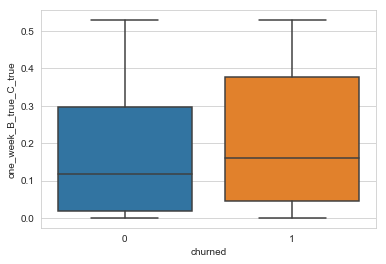

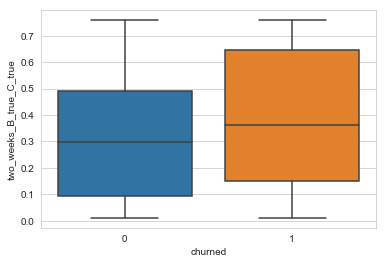

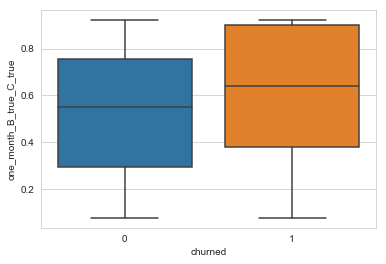

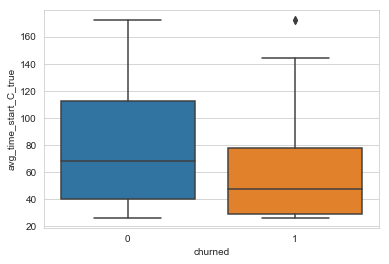

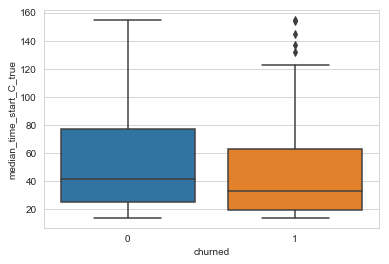

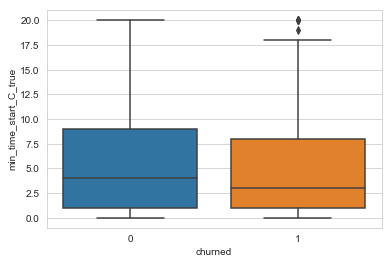

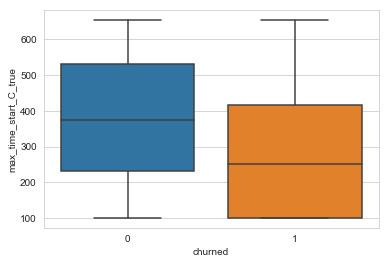

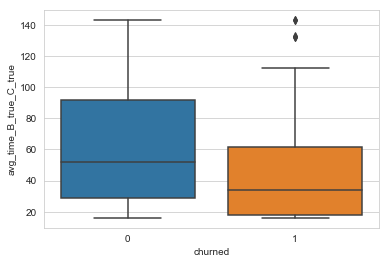

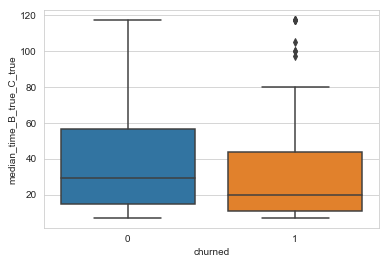

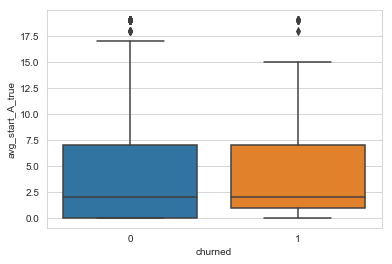

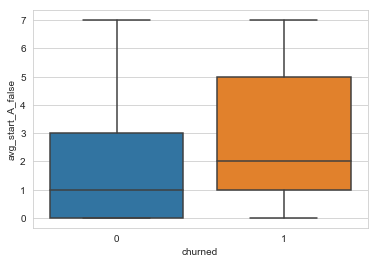

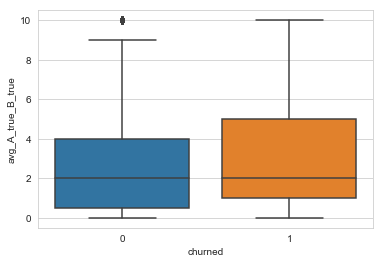

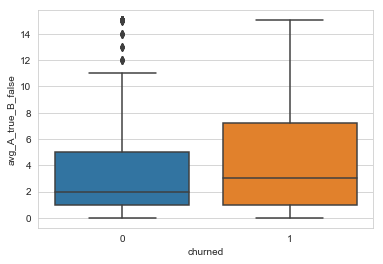

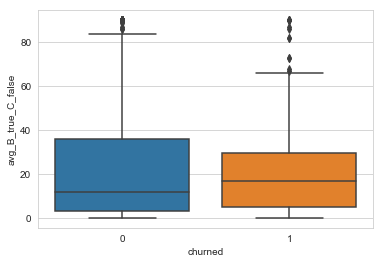

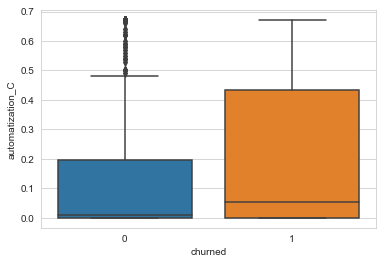

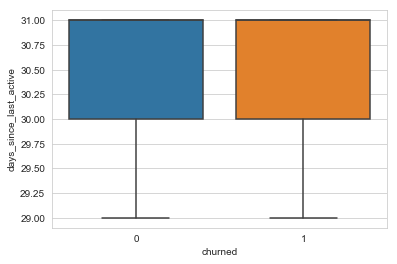

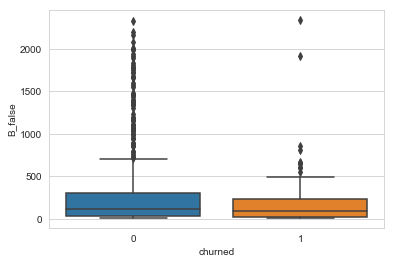

In [33]:
cp.plot_box(customer, numl, 'churned')

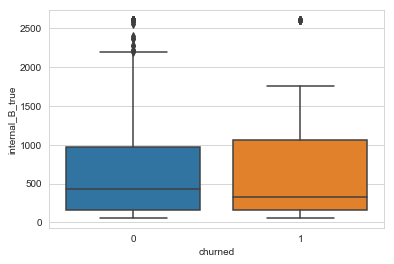

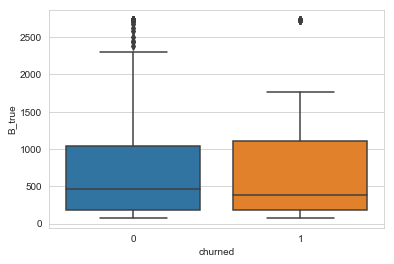

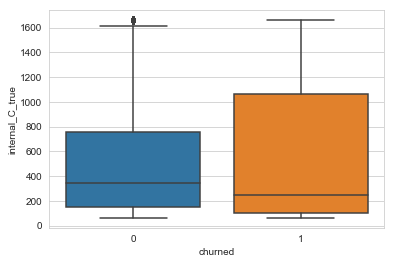

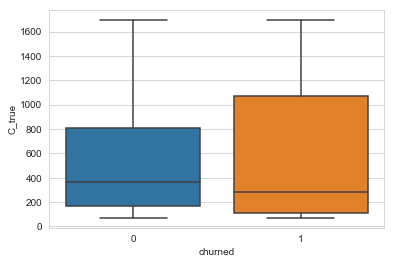

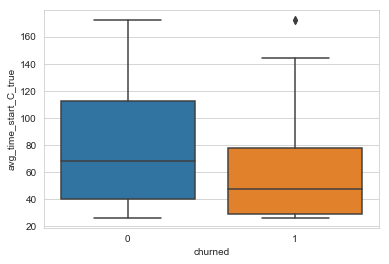

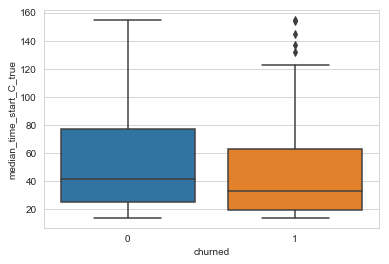

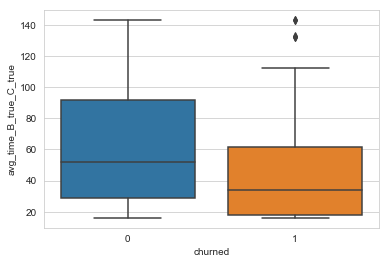

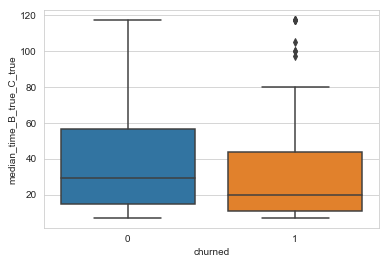

In [34]:
to_inspect = ['internal_B_true','B_true', 
            'internal_C_true', 'C_true', 
            'avg_time_start_C_true','median_time_start_C_true', 
            'avg_time_B_true_C_true', 'median_time_B_true_C_true']

cp.plot_box(customer,to_inspect,'churned')

In [35]:
customer.drop(['B_true', 
            'C_true', 
            'median_time_start_C_true', 
            'median_time_B_true_C_true'], axis=1, inplace=True)

In [36]:
numl = ['contract_duration', 'A_true', 'A_false', 'internal_B_true',
        'external_B_true', 'internal_C_true', 'external_C_true', 
        'one_week_B_true_C_true', 'two_weeks_B_true_C_true',
        'one_month_B_true_C_true', 'avg_time_start_C_true',
        'min_time_start_C_true',
        'max_time_start_C_true', 'avg_time_B_true_C_true',
        'avg_start_A_true', 'avg_start_A_false',
        'avg_A_true_B_true', 'avg_A_true_B_false', 'avg_B_true_C_false',
        'automatization_C', 'B_false', 'days_since_last_active']

In [37]:
y = customer.churned
numl_feats = customer[numl]

scl = pp.StandardScaler()
X_scl = scl.fit(numl_feats)
X_std = pd.DataFrame(X_scl.transform(numl_feats), columns=numl)

rfe = RFE(XGBClassifier(n_estimators=30, random_state=1), n_features_to_select=15)
fit = rfe.fit(X_std, y)

print('Selected Features:')
selected = []

for i in range(len(fit.support_)):
    if fit.support_[i]:
        sel = numl_feats.columns[i]
        selected += [sel]
        print(sel)
        
numl = selected

Selected Features:
contract_duration
A_true
A_false
external_B_true
internal_C_true
external_C_true
one_month_B_true_C_true
avg_time_start_C_true
min_time_start_C_true
max_time_start_C_true
avg_time_B_true_C_true
avg_start_A_false
avg_B_true_C_false
automatization_C
days_since_last_active


## Training  <a class="anchor" id="traintest"></a>

In [38]:
X = cm.get_dummies(customer[catg + numl], catg)
y = customer[['churned']]

is_numl = X.columns.map(lambda x : True if x in numl else False)
numl_ix = pd.Series(range(X.shape[1]))[is_numl]

cnts = y.churned.value_counts()
w0 = cnts[1]/len(y)
w1 = cnts[0]/len(y)

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.15, random_state = 10)

### Exploring the Hyperparameter Space  <a class="anchor" id="space"></a>

[Experiment n_estimators=20] Average Test PR-AUC: 0.9812088999999999
[Experiment n_estimators=30] Average Test PR-AUC: 0.9846121333333335
[Experiment n_estimators=40] Average Test PR-AUC: 0.9863059000000001
[Experiment n_estimators=50] Average Test PR-AUC: 0.9867107666666668
[Experiment n_estimators=100] Average Test PR-AUC: 0.9825223333333336
[Experiment n_estimators=200] Average Test PR-AUC: 0.9784521666666667
[Experiment n_estimators=500] Average Test PR-AUC: 0.9728091333333334


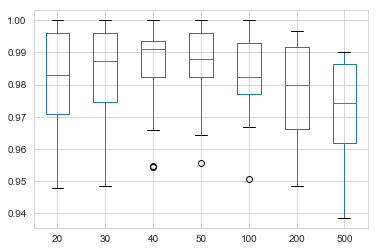

In [39]:
params = {'n_estimators':30, 
          'subsample':1, 
          'colsample_bytree':0.8,
          'colsample_bylevel':1,
          'colsample_bynode':0.5,
          'gamma': 0,
          'learning_rate': 0.2,
          'max_depth': 7,
          'min_child_weight': 1,
          'reg_alpha': 0,
          'reg_lambda': 1,
          'scale_pos_weight':math.floor(cnts[0]/cnts[1])}


ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'n_estimators', [20,30,40,50,100,200,500])

[Experiment gamma=0] Average Test PR-AUC: 0.9863059000000001
[Experiment gamma=1] Average Test PR-AUC: 0.9867695000000002
[Experiment gamma=5] Average Test PR-AUC: 0.9882271333333336
[Experiment gamma=10] Average Test PR-AUC: 0.9849786666666667
[Experiment gamma=15] Average Test PR-AUC: 0.9799627666666668


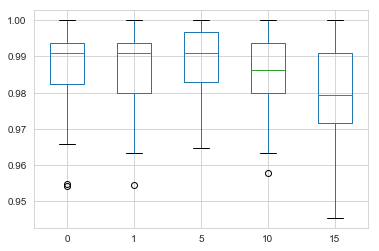

In [40]:
params['n_estimators'] = 40
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'gamma', [0,1,5,10,15])

[Experiment learning_rate=0.05] Average Test PR-AUC: 0.9821877000000003
[Experiment learning_rate=0.1] Average Test PR-AUC: 0.9882608000000002
[Experiment learning_rate=0.15] Average Test PR-AUC: 0.9878358000000002
[Experiment learning_rate=0.2] Average Test PR-AUC: 0.9882271333333336
[Experiment learning_rate=0.25] Average Test PR-AUC: 0.9866877666666667
[Experiment learning_rate=0.3] Average Test PR-AUC: 0.9862896333333335
[Experiment learning_rate=0.35] Average Test PR-AUC: 0.9839761
[Experiment learning_rate=0.4] Average Test PR-AUC: 0.9802900666666667


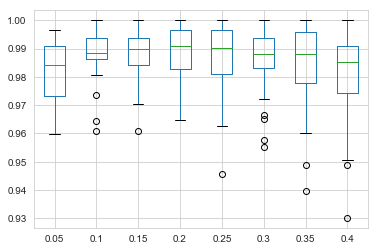

In [41]:
params['gamma'] = 5
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'learning_rate', [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.40])

[Experiment max_depth=3] Average Test PR-AUC: 0.9698718666666666
[Experiment max_depth=6] Average Test PR-AUC: 0.9869742666666668
[Experiment max_depth=9] Average Test PR-AUC: 0.9856903333333336
[Experiment max_depth=18] Average Test PR-AUC: 0.9882381333333335
[Experiment max_depth=36] Average Test PR-AUC: 0.9882381333333335
[Experiment max_depth=72] Average Test PR-AUC: 0.9882381333333335


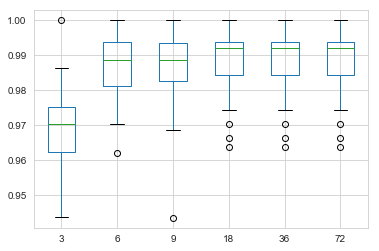

In [42]:
params['learning_rate'] = 0.2
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'max_depth', [3,6,9,18,36,72])

[Experiment min_child_weight=0] Average Test PR-AUC: 0.9859348333333335
[Experiment min_child_weight=1] Average Test PR-AUC: 0.9869742666666668
[Experiment min_child_weight=2] Average Test PR-AUC: 0.9841117000000001
[Experiment min_child_weight=5] Average Test PR-AUC: 0.9814653
[Experiment min_child_weight=20] Average Test PR-AUC: 0.9438947666666667


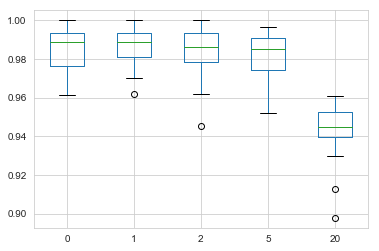

In [43]:
params['max_depth'] = 6
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'min_child_weight', [0,1,2,5,20])

[Experiment reg_alpha=0] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.0001] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.001] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.01] Average Test PR-AUC: 0.9869321000000001
[Experiment reg_alpha=0.1] Average Test PR-AUC: 0.9865978000000001
[Experiment reg_alpha=0.5] Average Test PR-AUC: 0.9853713333333334
[Experiment reg_alpha=1] Average Test PR-AUC: 0.9863408666666665


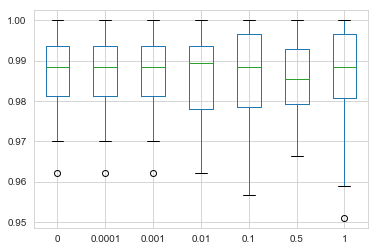

In [44]:
params['min_child_weight'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'reg_alpha', [0,0.0001,0.001,0.01,0.1,0.5,1])

[Experiment reg_lambda=0] Average Test PR-AUC: 0.9867909666666669
[Experiment reg_lambda=0.5] Average Test PR-AUC: 0.9876906666666667
[Experiment reg_lambda=1] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_lambda=2] Average Test PR-AUC: 0.9868845666666668
[Experiment reg_lambda=5] Average Test PR-AUC: 0.9819426
[Experiment reg_lambda=10] Average Test PR-AUC: 0.9777681666666668


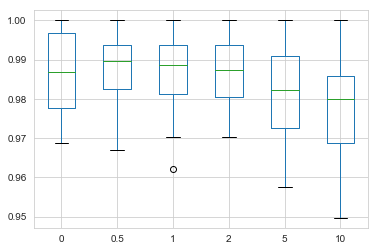

In [45]:
params['reg_alpha'] = 0
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'reg_lambda', [0,0.5,1,2,5,10])

[Experiment subsample=0.1] Average Test PR-AUC: 0.7555224333333332
[Experiment subsample=0.2] Average Test PR-AUC: 0.8649730999999999
[Experiment subsample=0.3] Average Test PR-AUC: 0.9119458666666667
[Experiment subsample=0.4] Average Test PR-AUC: 0.9406144
[Experiment subsample=0.5] Average Test PR-AUC: 0.9533843333333335
[Experiment subsample=0.6] Average Test PR-AUC: 0.9694302
[Experiment subsample=0.7] Average Test PR-AUC: 0.9788429666666668
[Experiment subsample=0.8] Average Test PR-AUC: 0.9816768666666669
[Experiment subsample=0.9] Average Test PR-AUC: 0.9863961666666669
[Experiment subsample=1] Average Test PR-AUC: 0.9876906666666667


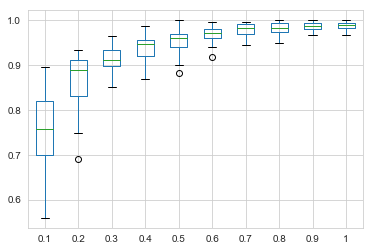

In [46]:
params['reg_lambda'] = 0.5
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'subsample', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

[Experiment colsample_bytree=0.25] Average Test PR-AUC: 0.8998631
[Experiment colsample_bytree=0.5] Average Test PR-AUC: 0.9770496666666667
[Experiment colsample_bytree=0.75] Average Test PR-AUC: 0.9870158333333333
[Experiment colsample_bytree=1] Average Test PR-AUC: 0.9898051333333334


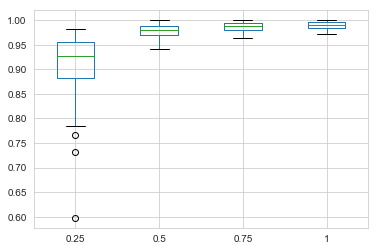

In [47]:
params['subsample'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bytree', [0.25,0.5,0.75,1])

[Experiment colsample_bylevel=0.25] Average Test PR-AUC: 0.9050301333333332
[Experiment colsample_bylevel=0.5] Average Test PR-AUC: 0.9597967666666667
[Experiment colsample_bylevel=0.75] Average Test PR-AUC: 0.9773030666666668
[Experiment colsample_bylevel=1] Average Test PR-AUC: 0.9898051333333334


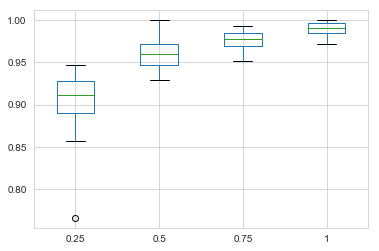

In [48]:
params['colsample_bytree'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bylevel', [0.25,0.5,0.75,1])

[Experiment colsample_bynode=0.25] Average Test PR-AUC: 0.9639053666666667
[Experiment colsample_bynode=0.5] Average Test PR-AUC: 0.9898051333333334
[Experiment colsample_bynode=0.75] Average Test PR-AUC: 0.9935787333333335
[Experiment colsample_bynode=1] Average Test PR-AUC: 0.9936390000000004


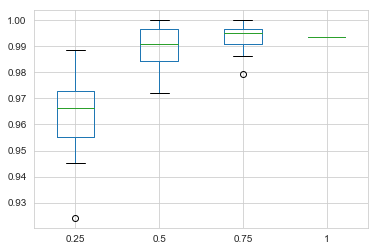

In [49]:
params['colsample_bylevel'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bynode', [0.25,0.5,0.75,1])

In [50]:
params['colsample_bynode'] = 0.75

### Hyperparameter Tuning  <a class="anchor" id="tuning"></a>

In [51]:
space = {
     'n_estimators': [30,40,50],
     'subsample': [1,0.9],
     'colsample_bytree': [1,0.9],
     'colsample_bylevel': [0.9,1],
     'colsample_bynode': [0.9,0.75],
     'gamma': [1,5],
     'learning_rate': [0.15,0.2,0.25],
     'max_depth': [6,7],
     'min_child_weight': [0,1],
     'reg_alpha': [0],
     'reg_lambda': [1,0.5],
     'scale_pos_weight': [6]
}

ca.nested_cross_validation(X_train, y_train, numl_ix, XGBClassifier(random_state=10, n_jobs=-1), space)

>> validation f1 = 0.9, train f1 = 0.97, threshold = 0.25, clf = {'colsample_bylevel': 1, 'colsample_bynode': 0.75, 'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 6, 'subsample': 1}
>> validation f1 = 0.82, train f1 = 0.98, threshold = 0.5, clf = {'colsample_bylevel': 0.9, 'colsample_bynode': 0.75, 'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 40, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 6, 'subsample': 0.9}
>> validation f1 = 0.85, train f1 = 0.97, threshold = 0.25, clf = {'colsample_bylevel': 0.9, 'colsample_bynode': 0.75, 'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 30, 'reg_alpha': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 6, 'subsample': 1}
>> validation f1 = 0.95, train f1 = 0.97, threshold = 0.75, clf = {'colsa

## Testing  <a class="anchor" id="results"></a>

In [52]:
best_params = {'colsample_bylevel': 1, 
               'colsample_bynode': 0.75, 
               'colsample_bytree': 1, 
               'gamma': 1, 
               'learning_rate': 0.15, 
               'max_depth': 7, 
               'min_child_weight': 0, 
               'n_estimators': 50, 
               'reg_alpha': 0, 
               'reg_lambda': 0.5, 
               'scale_pos_weight': 6, 
               'subsample': 1}

best_clf = XGBClassifier(**best_params, random_state=10, n_jobs=-1)

model = best_clf.fit(X_train, y_train)
probs = model.predict_proba(X_test)
xgb_preds = ca.classify(probs,  0.75)

ca.print_clf_metrics(y_test.churned,xgb_preds)

#any(xgb_preds != y_test.churned.values)

                 Confusion Matrix
                 Pred. Negative    Pred. Positive
True Negative       82                 0
True Positive        1                16

Accuracy   0.99
ROC-AUC    0.97
 
             Positive      Negative
Num. cases     17          82
Precision    1.00          0.99
Recall       0.94          1.00
F1           0.97          0.99


# Results Analysis <a class="anchor" id="analysis"></a>

## Important Features <a class="anchor" id="importance"></a>

XGBoost calculates features' importance quite naturally, so we take advantage of this fact to select which features to analyse closely and derive insights from. We choose the *gain* metric for this purpose, because it tells us which features brought more information (measured in entropy) on average when assembling the trees, i.e. the features that separate customers with high probability of churning from customers with low probabilities of churning more precisely and effectively.

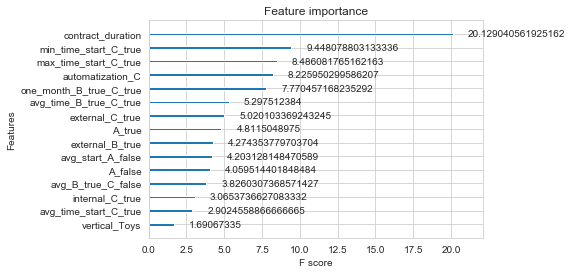

In [53]:
plot_importance(model, importance_type='gain')

In [54]:
important = ['contract_duration', 
             'min_time_start_C_true',
             'max_time_start_C_true',
             'automatization_C',
             'avg_time_B_true_C_true',
             'one_month_B_true_C_true']

## Probabilities and Percentiles <a class="anchor" id="probs"></a>

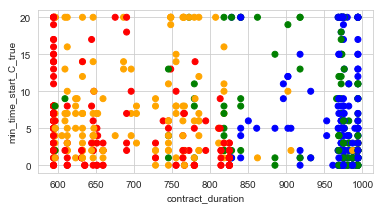

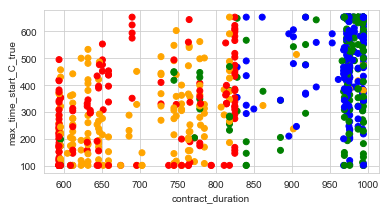

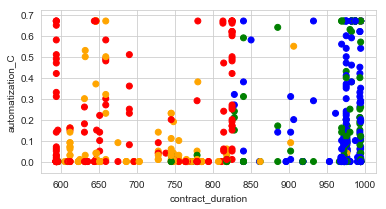

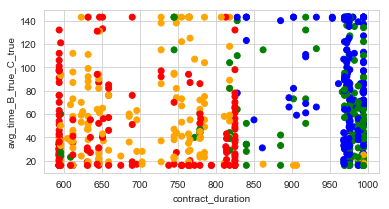

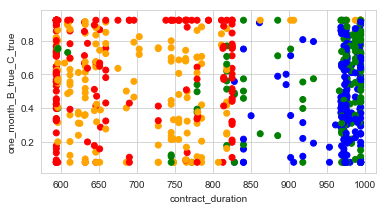

In [55]:
X = cm.get_dummies(customer[catg + numl], catg)
y = customer[['churned']]

probs = model.predict_proba(X)[:,1]
X['prob_churn'] = probs

percs = ['0-.25', '.25-.5', '.5-.75','.75-1']
X['percentile_churn'] = pd.qcut(X['prob_churn'], q = [0, .25, .50, .75, 1], labels = percs)

pairs = [('contract_duration',i) for i in important[1:]]
    
for pair in pairs:
    cp.plot_percentiles(X, pair, X['percentile_churn'],percs)

In [56]:
def print_summary(feat):
    print('---------------------------------------------------')
    print(feat)
    print('---------------------------------------------------')
    print(X.groupby('percentile_churn')[feat].describe().loc[:,['mean','std','50%']])
    print('---------------------------------------------------')
    
signif_numl = pd.DataFrame(index = important)

def calc_signif(c0, c1, c2, c3):
    p03 = ss.ttest_ind(c0, c3)[1]
    p01 = ss.ttest_ind(c0, c1)[1]
    p12 = ss.ttest_ind(c1, c2)[1]
    p23 = ss.ttest_ind(c2, c3)[1]
    return p03 < 0.01, p01 < 0.01, p12 < 0.01, p23 < 0.01

c = X.percentile_churn
signif_numl = X[important].apply(lambda x : calc_signif(x[c==percs[0]],x[c==percs[1]], x[c==percs[2]], x[c==percs[3]]))
    


In [57]:
print_summary(important[0])
print(signif_numl[important[0]])

---------------------------------------------------
contract_duration
---------------------------------------------------
                        mean        std    50%
percentile_churn                              
0-.25             968.952128  35.555528  975.0
.25-.5            937.915493  89.342079  976.0
.5-.75            706.408537  95.414486  696.0
.75-1             681.333333  93.376718  646.0
---------------------------------------------------
(True, True, True, False)


In [58]:
print_summary(important[1])
print(signif_numl[important[1]])
print("")
print_summary(important[2])
print(signif_numl[important[2]])
print("")
print_summary(important[4])
print(signif_numl[important[4]])

---------------------------------------------------
min_time_start_C_true
---------------------------------------------------
                      mean       std  50%
percentile_churn                         
0-.25             6.170213  6.796725  3.0
.25-.5            5.887324  6.728892  2.5
.5-.75            6.731707  6.140580  5.0
.75-1             5.048485  5.492574  3.0
---------------------------------------------------
(False, False, False, True)

---------------------------------------------------
max_time_start_C_true
---------------------------------------------------
                        mean         std    50%
percentile_churn                               
0-.25             476.877021  147.847867  470.0
.25-.5            430.280000  180.093185  451.0
.5-.75            281.198293  135.484129  265.5
.75-1             275.184727  160.609776  247.0
---------------------------------------------------
(True, False, True, False)

-----------------------------------------------

In [59]:
print_summary(important[3])
print(signif_numl[important[3]])

---------------------------------------------------
automatization_C
---------------------------------------------------
                      mean       std    50%
percentile_churn                           
0-.25             0.173181  0.230456  0.060
.25-.5            0.198521  0.265999  0.045
.5-.75            0.080085  0.181338  0.000
.75-1             0.173905  0.240095  0.010
---------------------------------------------------
(False, False, True, True)


In [60]:
print_summary(important[5])
print(signif_numl[important[5]])

---------------------------------------------------
one_month_B_true_C_true
---------------------------------------------------
                      mean       std       50%
percentile_churn                              
0-.25             0.443755  0.268476  0.426123
.25-.5            0.546153  0.265873  0.571271
.5-.75            0.518895  0.273397  0.556944
.75-1             0.620630  0.286467  0.672500
---------------------------------------------------
(True, True, False, True)


### Behavioural Patterns <a class="anchor" id="patterns"></a>

In [61]:
customer_with_id = customer_with_id.dropna(subset = with_nas)
customer_with_id[info_cols] = customer_with_id[info_cols].fillna('NotAvailable')
customer_with_id[numl] = customer_with_id[numl].apply(subs_outliers)

In [62]:
series = pd.concat([customer_with_id[important + ['churned','customer','contractid']],X['prob_churn']],axis=1)

In [63]:
len(series.customer.unique()) == len(series.contractid.unique())

True

In [64]:
series['tick'] = series.groupby('customer').cumcount()

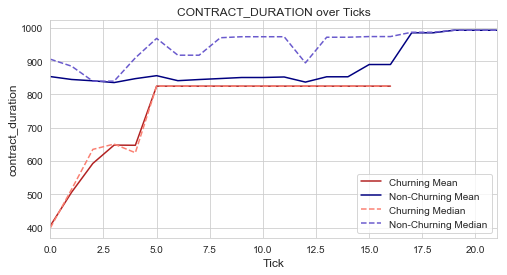

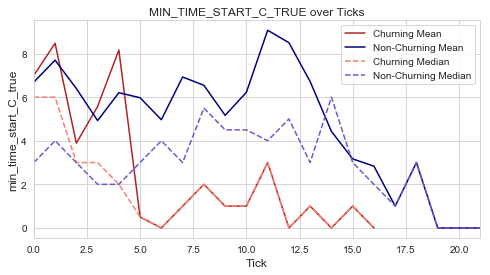

In [65]:
positive = series.loc[series.churned == 1,:].drop('churned',axis=1)
negative = series.loc[series.churned == 0,:].drop('churned',axis=1)

def plot_cases(column):

    pos_means = positive.groupby('tick')[column].mean()
    neg_means = negative.groupby('tick')[column].mean()
    pos_medians = positive.groupby('tick')[column].median()
    neg_medians = negative.groupby('tick')[column].median()
    
    fig = plt.figure(figsize=(8, 4))
    pos_means.plot(c='firebrick', label='Churning Mean')
    neg_means.plot(c='navy', label='Non-Churning Mean')
    pos_medians.plot(c='salmon', style='--', label='Churning Median')
    neg_medians.plot(c='slateblue', style='--', label='Non-Churning Median')  
    plt.xlabel("Tick", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.legend(fontsize=10)
    plt.title(column.upper() + ' over Ticks')


#important = important[1:] 

plot_cases(important[0])
plot_cases(important[1])

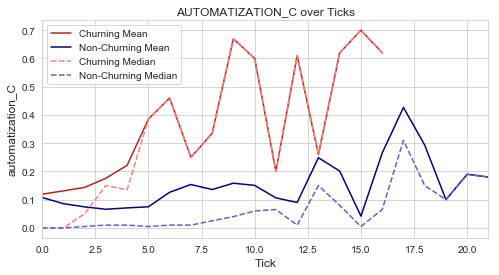

In [66]:
plot_cases(important[3])

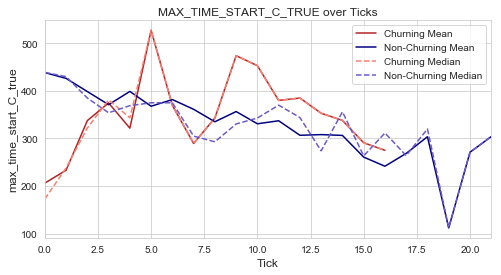

In [67]:
plot_cases(important[2])

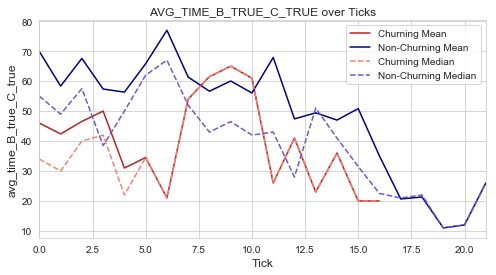

In [68]:
plot_cases(important[4])

# Recommendations <a class="anchor" id="recommendations"></a>

# Appendix <a class="anchor" id="appendix"></a>

In [69]:
from sklearn.linear_model import LogisticRegression

scl = pp.StandardScaler()
X_scl = scl.fit(X_train[numl])
X_std = X_train.copy()
X_std[numl] = X_scl.transform(X_train[numl])

space = {'C': [0.5, 1,10,20,50,100,200,500,1000],
 'class_weight': [{0:w0,1:w1}],
 'fit_intercept': [True,False],
 'penalty': ['l1','l2']}

ca.nested_cross_validation(X_std, y, numl_ix, LogisticRegression(), space, ts = np.linspace(0.2,0.8,7))

>> validation f1 = 0.26, train f1 = 0.61, threshold = 0.2, clf = {'C': 20, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
>> validation f1 = 0.21, train f1 = 0.58, threshold = 0.2, clf = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': True, 'penalty': 'l2'}
>> validation f1 = 0.28, train f1 = 0.64, threshold = 0.2, clf = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
>> validation f1 = 0.27, train f1 = 0.6, threshold = 0.5, clf = {'C': 100, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': True, 'penalty': 'l2'}
>> validation f1 = 0.2, train f1 = 0.57, threshold = 0.4, clf = {'C': 200, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
Mean validation results:
F1: 0.244 (0.034)
AUC: 0.521 (0.036)
Accuracy: 0.293 (0.202)


In [70]:
best_params = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
best_clf = LogisticRegression(**best_params)

X_scl = scl.fit(X_test[numl])
X_std_test = X_test.copy()
X_std_test[numl] = X_scl.transform(X_test[numl])

model = best_clf.fit(X_std, y_train)
probs = model.predict_proba(X_std_test)
lrg_preds = ca.classify(probs,  0.2)

ca.print_clf_metrics(y_test,lrg_preds)

                 Confusion Matrix
                 Pred. Negative    Pred. Positive
True Negative       46                36
True Positive        0                17

Accuracy   0.64
ROC-AUC    0.78
 
             Positive      Negative
Num. cases     17          82
Precision    0.32          1.00
Recall       1.00          0.56
F1           0.49          0.72


In [71]:
17+82

99